In [1]:
#load libraries 
import torch
from torchvision import transforms
import torch.nn as nn
from torchinfo import summary
from torch.utils.data import Dataset,DataLoader
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import numpy as np
from pathlib import Path
from PIL import Image

In [2]:
# read the data
root_dir = "../data/raw/breast_ultrasound/Dataset_BUSI_with_GT/"

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
path = Path(root_dir)

In [5]:
path.is_dir()

True

In [6]:
# Get all image paths (of all the orignal images Only)
image_paths = list(path.glob("*/*).png"))
print(len(image_paths))

780


In [7]:
# Extract labels froom folder names 
labels = [path.parent.name for path in image_paths]


In [8]:
print("Number of images from Benign",labels.count("benign") )
print("Number of images from normal",labels.count("normal") )
print("Number of images from malignant",labels.count("malignant"))

Number of images from Benign 437
Number of images from normal 133
Number of images from malignant 210


In [9]:
# Label encoding the labels 
from sklearn.preprocessing import LabelEncoder

label_encode = LabelEncoder()

In [10]:
target_labels = label_encode.fit_transform(labels)

In [11]:
image_paths = np.array(image_paths)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    image_paths,
    target_labels,
    test_size=0.2,        # 20% test
    random_state=42,
    shuffle=True,
    stratify=target_labels  # VERY important for classification
)

In [13]:
# build custom dataset and dataloader 
class CustomDataset(Dataset): 
    def __init__(self,image_paths,labels): 
        self.images = image_paths
        self.labels = labels


    def __len__(self): 
        return len(self.images)


    def __getitem__(self,index):
        images = Image.open(self.images[index]).convert("RGB")
        
        # Convert to Tensor 
        images = transforms.ToTensor()(images)
        # Resize the image size
        resize_transform = transforms.Resize((224, 224))
        # Apply the transform
        resized_img = resize_transform(images)
        # labels 
        labels = torch.tensor(self.labels[index])
        return resized_img,labels

In [14]:
X_train_dataset = CustomDataset(X_train,y_train)
X_test_dataset = CustomDataset(X_test,y_test)

In [15]:
X_train_dataloader = DataLoader(X_train_dataset,batch_size=32,shuffle=True,drop_last=True)
X_test_dataloader = DataLoader(X_test_dataset,batch_size=32,shuffle=False,drop_last=True)

In [16]:
len(X_train_dataset)

624

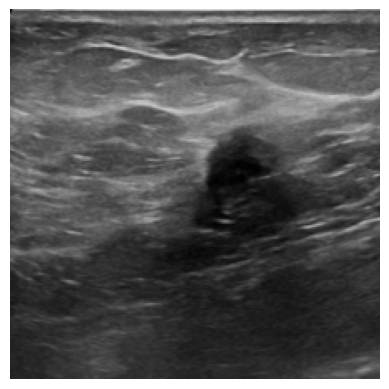

In [17]:

# Convert the tensor to channel-last format
image_np = X_train_dataset[90][0].permute(1, 2, 0).numpy()

# Display the image
plt.imshow(image_np)
plt.axis('off')  # Turn off axis labels
plt.show()

In [18]:
class MyModelEnhanced(nn.Module):
    def __init__(self, in_channels=3, num_classes=3):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.MaxPool2d(2),

            # Block 2
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2),

            # Block 3
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.MaxPool2d(2),

            # Block 4 (optional but powerful)
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.MaxPool2d(2),

            # Fix feature size
            nn.AdaptiveAvgPool2d((7, 7))
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [51]:
#torch.save(model.state_dict(), "./models/model_rgb_epoch_with_overlly_simplified.pth")


In [52]:
#model = MyModel(...)          # recreate architecture
#model.load_state_dict(torch.load("model.pth"))
#model.eval()


In [53]:
'''
accu : 92

specification : epochs = 50 and lr = 0.02

accu : 94 
specification : epochs = 75 and lr = 0.01

accu : 95
learning_rate = 0.01
epochs = 75
'''

'\naccu : 92\n\nspecification : epochs = 50 and lr = 0.02\n\naccu : 94 \nspecification : epochs = 75 and lr = 0.01\n\naccu : 95\nlearning_rate = 0.01\nepochs = 75\n'

In [59]:
# Configuration of My model 
learning_rate = 0.01
epochs = 35
loss_function = nn.CrossEntropyLoss()

In [60]:
# Improve the training 
import torch
from transformers import get_cosine_schedule_with_warmup
import matplotlib.pyplot as plt
model = MyModelEnhanced(3)
model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-4)
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=5 * len(X_train_dataloader),
    num_training_steps=epochs * len(X_train_dataloader)
)
# Lists to store metrics
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []


for epoch in range(epochs):
    model.train()
    total_train_loss, correct_train, total_train = 0, 0, 0
    for batch_images, batch_labels in X_train_dataloader:
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)

        optimizer.zero_grad()
        y_pred = model(batch_images)
        loss = loss_function(y_pred, batch_labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_train_loss += loss.item() * batch_images.size(0)
        _, predicted = torch.max(y_pred.data, 1)
        total_train += batch_labels.size(0)
        correct_train += (predicted == batch_labels).sum().item()

  
    avg_train_loss = total_train_loss / total_train
    train_acc = correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)


    # Evaluate on test set
    model.eval()
    total_test_loss, correct_test, total_test = 0, 0, 0
    all_probs ,all_labels = [],[]
    with torch.no_grad():
        for test_images, test_labels in X_test_dataloader:
            test_images, test_labels = test_images.to(device), test_labels.to(device)
            y_test_pred = model(test_images)
            loss_test = loss_function(y_test_pred, test_labels)

            total_test_loss += loss_test.item() * test_images.size(0)
            _, predicted_test = torch.max(y_test_pred.data, 1)
            total_test += test_labels.size(0)
            correct_test += (predicted_test == test_labels).sum().item()
        

    avg_test_loss = total_test_loss / total_test
    test_acc = correct_test / total_test
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_acc)



    # --------- ended here
    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.4f}")


Epoch [1/35] | Train Loss: 1.0428, Train Acc: 0.4984 | Test Loss: 1.0570, Test Acc: 0.5781
Epoch [2/35] | Train Loss: 0.9673, Train Acc: 0.5625 | Test Loss: 0.9997, Test Acc: 0.5781
Epoch [3/35] | Train Loss: 0.9414, Train Acc: 0.5592 | Test Loss: 0.9555, Test Acc: 0.5859
Epoch [4/35] | Train Loss: 0.8975, Train Acc: 0.6053 | Test Loss: 0.8738, Test Acc: 0.7188
Epoch [5/35] | Train Loss: 0.8903, Train Acc: 0.6250 | Test Loss: 0.8658, Test Acc: 0.6016
Epoch [6/35] | Train Loss: 0.8547, Train Acc: 0.6414 | Test Loss: 0.8088, Test Acc: 0.7109
Epoch [7/35] | Train Loss: 0.8098, Train Acc: 0.6628 | Test Loss: 0.9007, Test Acc: 0.6562
Epoch [8/35] | Train Loss: 0.7953, Train Acc: 0.6562 | Test Loss: 0.7905, Test Acc: 0.6406
Epoch [9/35] | Train Loss: 0.7380, Train Acc: 0.6842 | Test Loss: 0.7082, Test Acc: 0.7344
Epoch [10/35] | Train Loss: 0.7139, Train Acc: 0.7007 | Test Loss: 0.8942, Test Acc: 0.6484
Epoch [11/35] | Train Loss: 0.6793, Train Acc: 0.6941 | Test Loss: 0.6953, Test Acc: 0.71

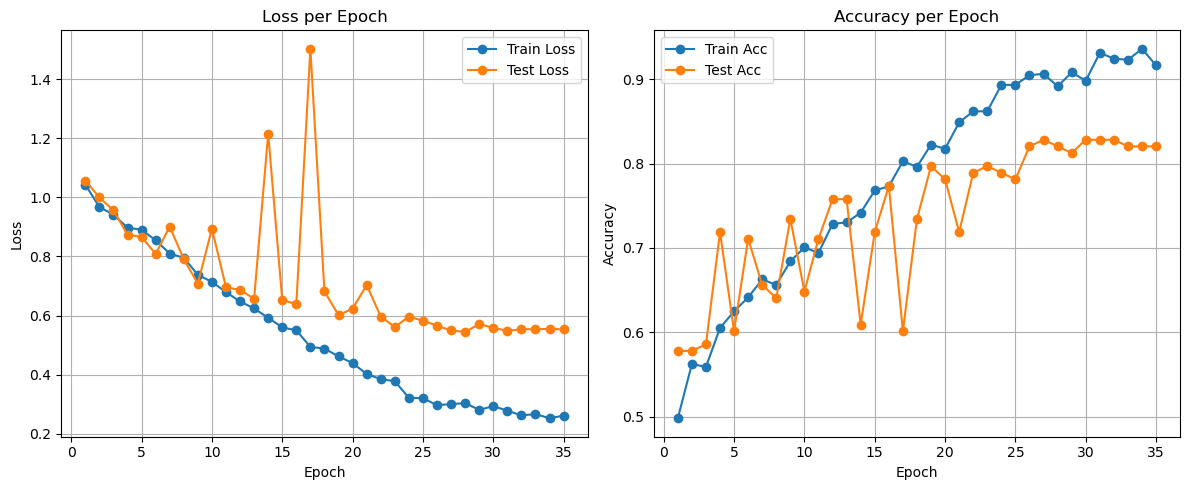

In [61]:
# Plot Loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss', marker='o')
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1,2,2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Acc', marker='o')
plt.plot(range(1, epochs+1), test_accuracies, label='Test Acc', marker='o')
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [62]:

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in X_test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()


In [63]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[65  3  6]
 [ 3 30  0]
 [10  1 10]]


In [64]:
from sklearn.metrics import classification_report

print(classification_report(
    all_labels,
    all_preds,
    target_names=["Benign", "Malignant", "Normal"]  # adjust order
))


              precision    recall  f1-score   support

      Benign       0.83      0.88      0.86        74
   Malignant       0.88      0.91      0.90        33
      Normal       0.62      0.48      0.54        21

    accuracy                           0.82       128
   macro avg       0.78      0.75      0.76       128
weighted avg       0.81      0.82      0.81       128



In [65]:
torch.save(model.state_dict(), "../models/model_orignal_35epoch.pth")

In [65]:
torch.save(model.state_dict(), "../models/model_orignal_35epoch.pth")